# 株価データ取得　
* http://stocks.finance.yahoo.co.jp/stocks/detail/?code=7731.T

In [13]:
# 第一引数に銘柄コード
# 第二引数に日付 (2015-01-01 など) 
# ディスコ 6146
# ニコン 7731
# タムロン 7740
# 日立ハイテクノロジー 8036

# スクリーン 7735
# アドテス 6857
# マニー 7730
# トプコン 7732
s = "2006-01-06"
e = "2016-11-18"
c = "7735"
#%run JpStock.py 7731 "2000-01-06" s e
#%run JpStock.py 8036 "2000-01-06"s e
#%run JpStock.py 6146 "2000-01-06"s e
%run JpStock.py {c} {s} {e}

Value Error occured in 7735 at jpstock.py
ErrorType: <class 'ValueError'>
ErrorMessage: cannot reindex from a duplicate axis


# 株価を予想する

In [4]:
import os
import ipyparallel as ipp
import sys,os,math
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from sklearn.tree import DecisionTreeClassifier

def get_ret_index(close):
    # リターンインデックス データーが昇順（日付が過去が上になって最新が一番下）になっている前提
    returns = pd.Series(close).pct_change() # 騰落率を求める
    ret_index = (1 + returns).cumprod() # 累積積を求める
    ret_index.iloc[0] = 1 # 最初の値を 1.0 にする
    return ret_index

def learn_data(arr,step):
    #train_X (教師データの配列) と train_y (それに対する 1 か 0 かのラベル) が戻る
    learn_X = []; 
    learn_y = [];
    flg=0;
    for i in np.arange(0, len(arr)-step):
        end = i + step# step日間の変化を素性にする
        data = arr.iloc[i:end]
        close= data['AdjClose']
        close.head()
        feature = get_ret_index(close)
        # その翌日、株価は上がったか？
        if close.iloc[-1] < arr['AdjClose'].iloc[end]:
            flg=1
        else:
            flg=0
        #print(close.iloc[-1],"<",arr['AdjClose'].iloc[end],flg)
        learn_X.append(feature.values)
        learn_y.append(flg) # YES なら 1  NO なら 0 
    # 上げ下げの結果と教師データのセットを返す
    return np.array(learn_X), np.array(learn_y)

def Judgement(tm, num, zz, st, a, b):
    CorrectFlg =True;
    if a > 0:
        if b == 1:
            Predict = "Rise"
        else:
            Predict = "Down"
            CorrectFlg =False;
    else:
        if b == 1:
            Predict = "Rise"
            CorrectFlg =False;
        else:
            Predict = "Down"
    print("{} {} {} step({}) {}-{}-{} [Predict : {}] Result: ¥{}".format(tm, num, CorrectFlg, st, zz.year,zz.month,zz.day,Predict, a))    
    return CorrectFlg


def calc_decision_tree_prdct(code, start, xday):
    "条件を変えながら、決定木で株価を予想する。"
    
    csvfile = "stock_{}.csv".format(str(code));    
    dic_score={}
    # 'M' is month-end, instead I need same-day-of-month
    #t_piriod= pd.date_range(start, xday, freq='M')
    t_piriod= pd.date_range(start, xday, freq='W')
    t_piriod=t_piriod[int(len(t_piriod)/5):-2]

    if os.path.isfile(csvfile):
        df = pd.read_csv(csvfile, index_col=0, parse_dates=True)
        #for st in np.arange(step-ofst,step+ofst,int(30)):
        s_st = 5;  # Calc Condition Start(day)
        e_st = 360; # Calc Condition End(day)
        width= 5;  # 1 Month
        mmm= np.arange(s_st,e_st,width)
        calc_cnt_all=len(mmm)*len(t_piriod); calc_cnt=0;
        data=[];
        for st in mmm:
            strike=[]
            for tt in t_piriod:
                calc_cnt=calc_cnt+1;
                CalcPrgsDisp="({}/{})".format(calc_cnt, calc_cnt_all)
                #1) 教師データ作成
                #start = datetime.datetime.strptime(start, '%Y-%m-%d')
                dx=df.loc[start:tt]
                dx = dx.dropna()
                LrnX,LrnY =learn_data(dx,st)

                #2) 学習させる
                # 決定木のインスタンスを生成
                clf = DecisionTreeClassifier()
                # 学習させる
                clf.fit(LrnX, LrnY)

                #3) 予測させる
                i=len(dx)-st
                #print(dx['AdjClose'][i:i+step].values.reshape(1,-1))
                result = clf.predict(dx['AdjClose'][i:i+st].values.reshape(1, -1))
                #print(result)
                #翌日取得（１日オフセット）
                for ofset_day in [1,2,3,4,5]:
                    zz =dx.index[-1]+ timedelta(days=ofset_day)
                    #予測日（翌日）の上下結果取得
                    if (len(df[df.index== zz]))!=0:
                        break
                    else:
                        pass
                        #print("...Retry maybe weekend day")
                xx = (df[df.index== zz].AdjClose[0]) - (df[df.index== dx.index[-1]].AdjClose[0])
                if not math.isnan(xx):
                    #print("{} {}".format(df[df.index== zz].AdjClose[0],(df[df.index== dx.index[-1]].AdjClose[0])))
                    tm=datetime.now().strftime("%Y/%m/%d %H:%M:%S")
                    data.append([tm,tt,zz,st,int(result[0]),xx,CalcPrgsDisp])
                    strike.append(Judgement(tm, CalcPrgsDisp, zz, st, int(xx),int(result[0])));
                else:
                    pass
                    #print("... Skip calc because of NAN")
            score=np.count_nonzero(strike)/float(len(strike))
            #print("Step {} : Winning percentage {}[%]".format(st, score*100))
            dic_score[st]=score;
        print("----- End calc_decision_tree_prdct -----")
        for k, v in dic_score.items():
            print("Step {} : Winning percentage {}[%]".format(k, v))
        #xx=pd.Series(dic_score)
        xx=pd.DataFrame(data,columns=["LogTime","VirtualDate","PredictDate","CalcCond","LrnResult","ActualValue","CalcCount"])
        out_csvfile = "stock_{}_decision_tree.csv".format(str(code));    
        xx.to_csv(out_csvfile)
    else:
        print("Nothing csv file")    
        
def calc_decision_tree(code, start, xday, step):
    "決定木で株価を予想する。stepの値はcalc_decision_tree_prdctで決定する"
    
    csvfile = "stock_{}.csv".format(str(code));    
    print("From {} to {} by {}".format(start,xday, step))
    if os.path.isfile(csvfile):
        #1) 教師データ作成
        df = pd.read_csv(csvfile, index_col=0, parse_dates=True)
        #start = datetime.datetime.strptime(start, '%Y-%m-%d')
        dx=df.loc[start:xday]
        dx = dx.dropna()
        
        step = int(step)
        LrnX,LrnY =learn_data(dx,step)

        #2) 学習させる
        # 決定木のインスタンスを生成
        clf = DecisionTreeClassifier()
        # 学習させる
        clf.fit(LrnX, LrnY)

        #3) 予測させる
        i=len(dx)-step
        #print(dx['AdjClose'][i:i+step].values.reshape(1,-1))
        result = clf.predict(dx['AdjClose'][i:i+step].values.reshape(1, -1))
        #print(result)

        #翌日取得（１日オフセット）
        zz =dx.index[-1]+ timedelta(days=1)
        #予測日（翌日）の上下結果取得
        xx = (df[df.index== zz].AdjClose[0]) - (df[df.index== dx.index[-1]].AdjClose[0])
        Judgement(zz, step, int(xx),int(result[0]));
    else:
        print("Nothing csv file")  
        
code = 7731 
start = "2006-01-06"
xday  = "2016-11-18"
calc_decision_tree_prdct(code, start, xday)        

rc = ipp.Client(profile='default')
#ar = rc[:].apply_async(os.getpid)
ar = rc[:].apply_async()
pid_map = ar.get_dict()
print(pid_map)

NameError: name 'step' is not defined

# 結果描画

stock_7731_decision_tree.csv
7731


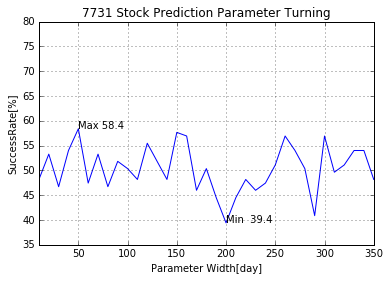

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob,os

#==========================================
def add_Bingo(xx):
    CorrectFlg =True;
    if xx['ActualValue'] > 0:
        if xx['LrnResult'] != 1:
            CorrectFlg =False;
    else:
        if xx['LrnResult'] == 1:
            CorrectFlg =False;
    return CorrectFlg
#==========================================
def check_bingo_rate(group):
    group['SuccessRate'] = (np.count_nonzero(list(group['Bingo2']))/group['Bingo2'].count())*100;
    return group
#==========================================
def get_files():
    codes=[]
    files = glob.glob('stock_*_decision_tree.csv') 
    for filecsv in files:
        print(filecsv)
        fn, ext= os.path.splitext( os.path.basename(filecsv))
        fnz=fn.split("stock_");
        if len(fnz) >1:
            if fnz[1].count('_'):
                fnz=fnz[1].split("_");
                codes.append(fnz[0])
                print(fnz[0])
    return codes;
#==========================================

code=7731
for code in get_files():
    csvfile = "stock_{}_decision_tree.csv".format(str(code));
    data = pd.read_csv(csvfile,header=0)
    data['code'] =int(7731)
    data['Bingo2'] =data.apply(add_Bingo,axis=1)
    data=data.groupby(['CalcCond']).apply(check_bingo_rate);

    df=data.drop("Unnamed: 0", axis=1)
    grouped = df.groupby(['CalcCond']).mean()
    grouped.head()

    fig = grouped['SuccessRate'].plot().get_figure()
    plt.grid(); plt.title('{} Stock Prediction Parameter Turning'.format(str(code))) ; 
    plt.ylabel('SuccessRate[%]'); 
    plt.xlabel('Parameter Width[day]'); 
    plt.ylim([35,80])
    ax = fig.gca()
    ax.text(grouped['SuccessRate'].idxmax(), grouped['SuccessRate'].max(), "Max {0:.1f}".format(grouped['SuccessRate'].max()))
    ax.text(grouped['SuccessRate'].idxmin(),  grouped['SuccessRate'].min(),  "Min  {0:.1f}".format(grouped['SuccessRate'].min()))
    pngfile="stock_{}_decision_tree.png".format(str(code));
    fig.savefig(pngfile)